In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import baltic as bt
from itertools import combinations, product
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
titer_file = '../data/titers_katzelnick2015/normalized_titers.csv'
tree_file = '../data/trees/titered_annotated_tree.nexus'
colors = pickle.load(open('./colors.p', 'rb'))
out_path = './png/'

In [3]:
tree = bt.loadNexus(tree_file, absoluteTime=False)

In [4]:
def label_mrcas(tree):
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    
    for serotype in serotypes:
        serotype_tips = [k.numName for k in tree.leaves if k.numName.startswith(serotype)]

        mrca = sorted([node for node in tree.nodes 
                       if all([l in node.leaves for l in serotype_tips])], 
                     key = lambda n: node.height)[-1]
        mrca.traits['mrca'] = serotype
    
label_mrcas(tree)

In [5]:
titers = pd.read_csv(titer_file, sep=',', index_col=None)
titers = titers.pivot(index='virus', columns='serum', values='titer')

titered_strains = set(titers.columns.values).union(set(titers.index.values))
tip_order = [ k.numName for k in sorted(tree.Objects, key = lambda k: -1*k.y) if k.branchType=='leaf']
# serotype_tip_order = { s: [k for k in tip_order if k.startswith('DENV%d'%s) and k in titered_strains] 
#                       for s in [1,2,3,4]}

titers = titers.reindex(index =tip_order,columns=tip_order)

titers = titers.dropna(axis=0, how='all')
titers = titers.dropna(axis=1, how='all')
titers.index.name = None
titers.columns.name = None

In [6]:
titers.to_csv('./attachments/titer_heatmap.csv')

In [7]:
def plot_tree(tree, ax):
    
    ysf = 1.0#2.5 #yscale factor
    
    branchWidth=2 ## default branch width
    ll = tree
    plt.yticks(size=0)
        
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y*ysf ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=30 ## tip size can be fixed
            
            plt.plot((x,tree.treeHeight*1.1), (y,y), c='lightgray', linestyle='--')
#             plt.text(tree.treeHeight*1.35, y, k.numName, fontsize=9, va='center', ha='right')
            plt.scatter(x,y,s=s,facecolor='k',edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y*ysf,k.children[0].y*ysf],lw=branchWidth,color='k',ls='-',zorder=9)
            
            if 'mrca' in k.traits:
                ax.text((xp+x)/2., y+0.5, k.traits['mrca'])
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color='k',ls='-',zorder=9)

        
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_bounds(0,tree.treeHeight)
    y0,y1 = ax.get_ylim()
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].label1.set_visible(False)
    xticks[-1].label1.set_visible(False)
    xticks[-2].label1.set_visible(False)
    ax.set_xlabel('Substitutions per site', fontsize=14)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
 

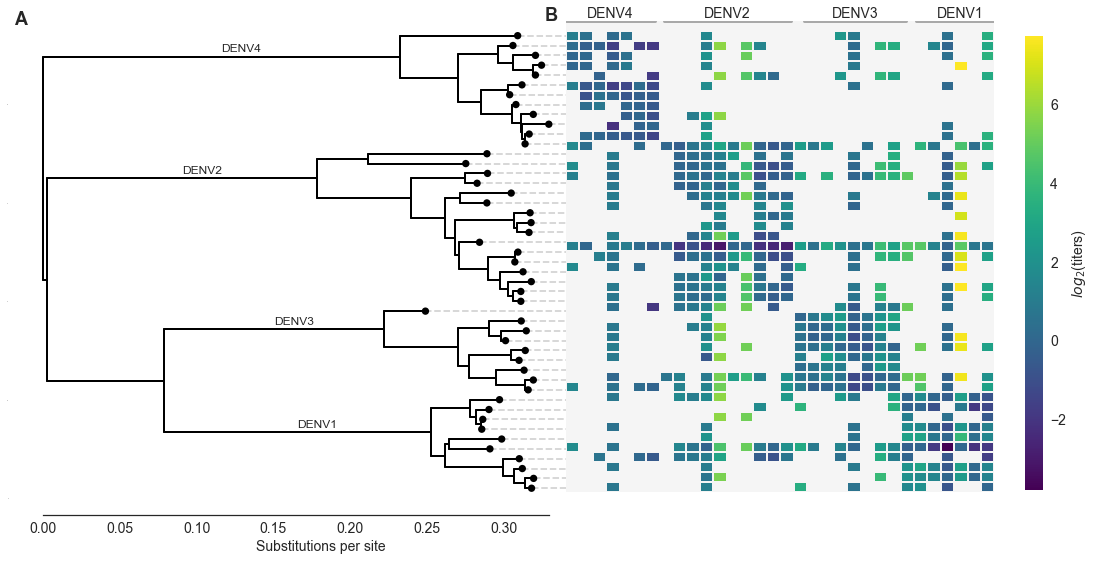

In [8]:
def add_subfigure_label(ax, label, x=-0.05, y=1.0):
    ax.text(x, y, label, va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=ax.transAxes)

sns.set(style='white', font_scale=1.)
fig = plt.figure(figsize=(8.5,7))
tree_ax = fig.add_axes([0,0,1,1])
heatmap_ax = fig.add_axes([0.9,0.045,0.7,0.935])
cbar_ax = fig.add_axes([1.65,0.05,0.03,0.9])

plt.sca(tree_ax)
plot_tree(tree, tree_ax)
plt.sca(heatmap_ax)

heatmap_ax.set_facecolor('whitesmoke')
sns.heatmap(titers, ax=heatmap_ax, cbar_kws={'label': r'$log_2$(titers)'}, 
            cmap='viridis',  yticklabels=False, xticklabels = False,
            cbar_ax=cbar_ax,linewidths=1,linecolor='whitesmoke')
heatmap_ax.figure.axes[-1].yaxis.label.set_size(14)
cbar_ax.tick_params(labelsize=14)

    
serotype_order = ['DENV4', 'DENV2', 'DENV3', 'DENV1']
serotype_proportion = {s: len([t for t in titers.columns.values if t.startswith(s)])/float(len(titers.columns.values)) for s in serotype_order}

x0, xf = heatmap_ax.get_xlim()#0.,1.
y0, yf = heatmap_ax.get_ylim()
x=x0
for serotype in serotype_order:
    length = xf*serotype_proportion[serotype]*0.95
    heatmap_ax.plot((x, x+length), (yf-1,yf-1), c='darkgray', lw=3)#, transform=heatmap_ax.transAxes)
    heatmap_ax.text((x+x+length)/2., -1, serotype, ha='center', va='bottom', fontsize=14)#transform=heatmap_ax.transAxes)
    x += length*1.1
heatmap_ax.set_ylim(y0,yf-1)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

tree_ax.text(0, 1, 'A', va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=tree_ax.transAxes)
heatmap_ax.text(-0.05, 1.03, 'B', va='top', fontdict={'fontsize': 18, 'fontweight': 'bold'}, transform=heatmap_ax.transAxes)
plt.savefig('./png/titer_tree_heatmap.png', dpi=300, bbox_inches='tight')

In [22]:
# def split_serotypes(df, serotype_tip_order=serotype_tip_order):
#     '''Return dictionary of {virus_rows: {sera_column: df}} for plotting heatmap small multiples'''
#     columns = {}
#     rows = {}
#     for serotype in [1,2,3,4]:
#         columns[serotype] = [s for s in serotype_tip_order[serotype] if s in df.columns.values]
#         extra_sera = [ s for s in df.columns.values if s.startswith('DENV%d'%serotype) and s not in columns[serotype] ]
#         columns[serotype] += extra_sera
        
#         rows[serotype] = [v for v in serotype_tip_order[serotype] if v in df.index.values]
#         extra_viruses = [v for v in df.index.values if v.startswith('DENV%d'%serotype) and v not in rows[serotype]]
# #         rows[serotype] += extra_viruses
    
# #     columns = { s : [ i for i in df.columns.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
# #     rows = { s : [i for i in df.index.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }

#     split_serotypes = {1: {}, 2: {}, 3: {}, 4: {}} # { serotype_1_viruses: {vs_serotype_1_sera: partial_df, vs_2: ...}, ...}
    
#     for serum_serotype in [1,2,3,4]:
#         for virus_serotype in [1,2,3,4]:
#             partial_design_matrix = df.loc[rows[virus_serotype], columns[serum_serotype]]
#             split_serotypes[serum_serotype][virus_serotype] = partial_design_matrix
#     return split_serotypes

# def plot_small_multiples(titer_df, cmap=colors['cmap']):
#     data = split_serotypes(titer_df)
#     sns.set(style='dark', font_scale=1.2)

#     ## Set subplot size ratios
#     width_ratios = [ len(data[i][1].columns.values) for i in [1,2,3,4] ]
#     max_w = max(width_ratios)
#     width_ratios = [ i / float(max_w) for i in width_ratios ]
#     height_ratios = [ len(data[1][i].index.values) for i in [1,2,3,4]]
#     max_h = max(height_ratios)
#     height_ratios = [ i / float(max_h) for i in height_ratios ]    

#     fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7.5/2,7.5/2), facecolor='white',
#                              gridspec_kw={'wspace': 0.1, 'hspace':0.1,
#                             'width_ratios': width_ratios, 'height_ratios': height_ratios})

#     ## Set colors
#     cmap = plt.get_cmap(cmap)

#     all_values = []
#     for (virus, serum) in product([1,2,3,4], repeat=2):
#         all_values += [i for i in data[virus][serum].values.flatten() if not np.isnan(i) ]
#     vmin_val = float(min(all_values)) # Anchor color map for entire figure at global min/max values
#     vmax_val = float(max(all_values))
#     cbar_axis = fig.add_axes([1.0, 0.15, .03, 0.7])

#     for virus, row in enumerate(axes, start=1):
#         for serum, axis in enumerate(row, start=1):
#             if virus == 1 and serum == 4:
#                 cbar_bool = True
#             else:
#                 cbar_bool = False

#             plot = sns.heatmap(data[serum][virus], ax=axis, 
#                         vmin=vmin_val, vmax=vmax_val, cmap=cmap, xticklabels = False, yticklabels=False, 
#                        cbar = cbar_bool, cbar_ax=cbar_axis,
#                               cbar_kws={'label': r'Mean $log_2$(normalized titer)'})
#             axis.set_xlabel('')
#             axis.set_ylabel('')
#             if virus == 1:
#                 plot.set_title('DENV%d'%serum, fontsize=12)
                
#             if serum == 1:
#                 plot.set_ylabel('DENV%d'%virus, fontsize=12)
#                 if virus == 2:
#                     plt.text(-.75, 0, 'Virus',  transform=axis.transAxes, fontsize=14, ha='center', va='center', rotation='vertical')
#     plt.suptitle(' Sera', va='bottom', ha='center', fontsize=14)
#     return fig

In [23]:
# fig = plot_small_multiples(titers)
# tree_ax = fig.add_axes([1.8,0.05,0.03,0.9])

# # plt.savefig('./png/titer_heatmap.png', dpi=300, bbox_inches='tight')
# plt.show()